# Deep Learning at Neuromatch 2021
Tanvi Ranjan, August 2021
## Week 1, Day 4: Optimization (Jose-Gallego and colleagues)
[W1D4 tutorial](https://deeplearning.neuromatch.io/tutorials/W1D4_Optimization/student/W1D4_Tutorial1.html)

This tutorial is all about optimization parameters for training a neural network. There are many parameters to optimize when building a neural network for model prediction or classification, all in addition to choosing the structure of the neural network itself. The following is a list of some parameters:
* Learning rate:
    Too small a learning rate leads to slow convergence, too large leads to the parameters being bounced around a lot. Problem is solved by using Adaptive learning rate algos such as Adagrad which adapt learning rate for each layer $i$ based on previous gradients:
    $$ \eta_t = \frac{\eta}{\sqrt{[v_{t}]_i + \epsilon}}, [v_t]_i = \sum_{s=0}^{t}\nabla [J(w_s)]_i^2$$
    
    or RMS-prop, where   $[v_t]_i = \alpha [v_{t-1}]_i + (1-\alpha) \nabla ([J(w_s)]_i)^2$
    Adam = RMS-prop + momentum
* Conditioning:
    History of previous updates is completely disregarded (if not using a learning rate), use momentum for those purposes
    
* Long time to calculate gradients with Gradient descent
    Use stochastic gradient descent with mini-batches.
    How to choose batch-size? Choose the biggest that fits on GPU

In [24]:
import time
import copy
import torch
import torchvision
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [5]:
import random
import torch

def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
        random.seed(seed)
        np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


### Section 1: Optimization techniques
##### Section 1.2: MLP for image classification
Let's load the data (In NMA, they used a different function, but it is essentially the same), normalize it and subsample (for the purposes of this tutorial)

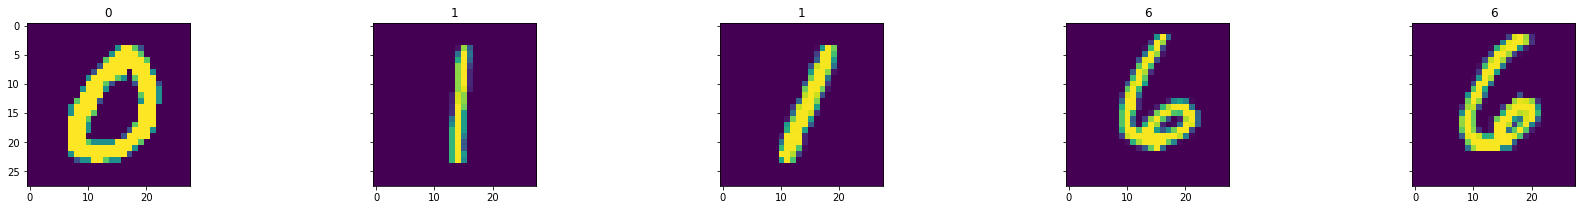

In [44]:
mnist_data_train = datasets.MNIST(root='./data',train=True,download=True,
                           transform=torchvision.transforms.ToTensor())
mnist_data_test = datasets.MNIST(root='./data',train=False,download=True,
                                transform =torchvision.transforms.ToTensor())

randidx = torch.randint(len(mnist_data_train), size=(5,))

f,ax = plt.subplots(1,5,figsize=(30,3),sharex=True,sharey=True)
for ir, rr in enumerate(randidx):
    img, label = mnist_data_train[rr];
    ax[ir].imshow(img.squeeze()); ax[ir].set_title(label)
    
train_mean, train_std = mnist_data_train.data.float().mean(), mnist_data_train.data.float().std();

mnist_data_train.data = (mnist_data_train.data.float() - train_mean)/train_std
mnist_data_test.data = (mnist_data_test.data.float() - train_mean)/train_std

Nchoose = 500;
choose_idx = np.random.choice(len(mnist_data_train),Nchoose)
X,y = mnist_data_train.data[Nchoose,], mnist_data_train.targets[Nchoose]

In [34]:
torch.randint(len(mnist_data_train), size=(5,))

tensor([22846,   662, 58380, 27295, 38590])